In [1]:
import sympy as sp
sp.init_printing()

import numpy as np
from numpy import kron
import math
from math import sqrt
from random import random

from scipy.optimize import linprog

import matplotlib.pyplot as plt

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## The Distribution with Dephasing noise

$|\psi> = \lambda_0 |01> + \lambda_1 |10>$

$\rho = (1-d) |\psi><\psi| + d (\lambda_0^2 |01><01| + \lambda_1^2 |10><10|)$ 

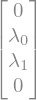

In [4]:
## settign states

# lambda_0 = 1/math.sqrt(2)
# lambda_1 = 1/math.sqrt(2)

d = sp.symbols('d')


lambda_0, lambda_1 = sp.symbols('lambda_0, lambda_1')

state_0 = np.array([1,0])
state_1 = np.array([0,1])

state_00 = kron(state_0,state_0).reshape(4,1)
state_01 = kron(state_0,state_1).reshape(4,1)
state_10 = kron(state_1,state_0).reshape(4,1)
state_11 = kron(state_1,state_1).reshape(4,1)

psi = (lambda_0*state_01 + lambda_1*state_10)

#sp.Matrix(psi)
sp.Array(psi)

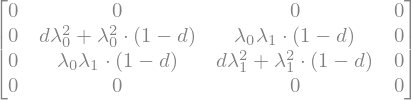

In [5]:
rho_noiseless = np.dot(psi, psi.T)
rho_dephasing = lambda_0**2 *np.dot(state_01, state_01.T) + lambda_1**2 *np.dot(state_10, state_10.T)

rho = (1-d)*rho_noiseless + d*rho_dephasing

sp.Matrix(rho)

In [6]:
total_rho = kron(kron(rho,rho),rho)


def new_index(x):   # 012345 --> 123450
    b  = bin(x)[2:].zfill(6) # x in binary b0..b5
    y = int(b[1:]+b[0], 2)
    return y

def change_qbit_order(x): # 012345 --> 123450
    x_ordered = np.zeros_like(x)
    for i in range(64):
        for j in range(64):
            x_ordered[new_index(i), new_index(j)] = x[i,j]
    return x_ordered

total_rho_ordered = change_qbit_order(total_rho)

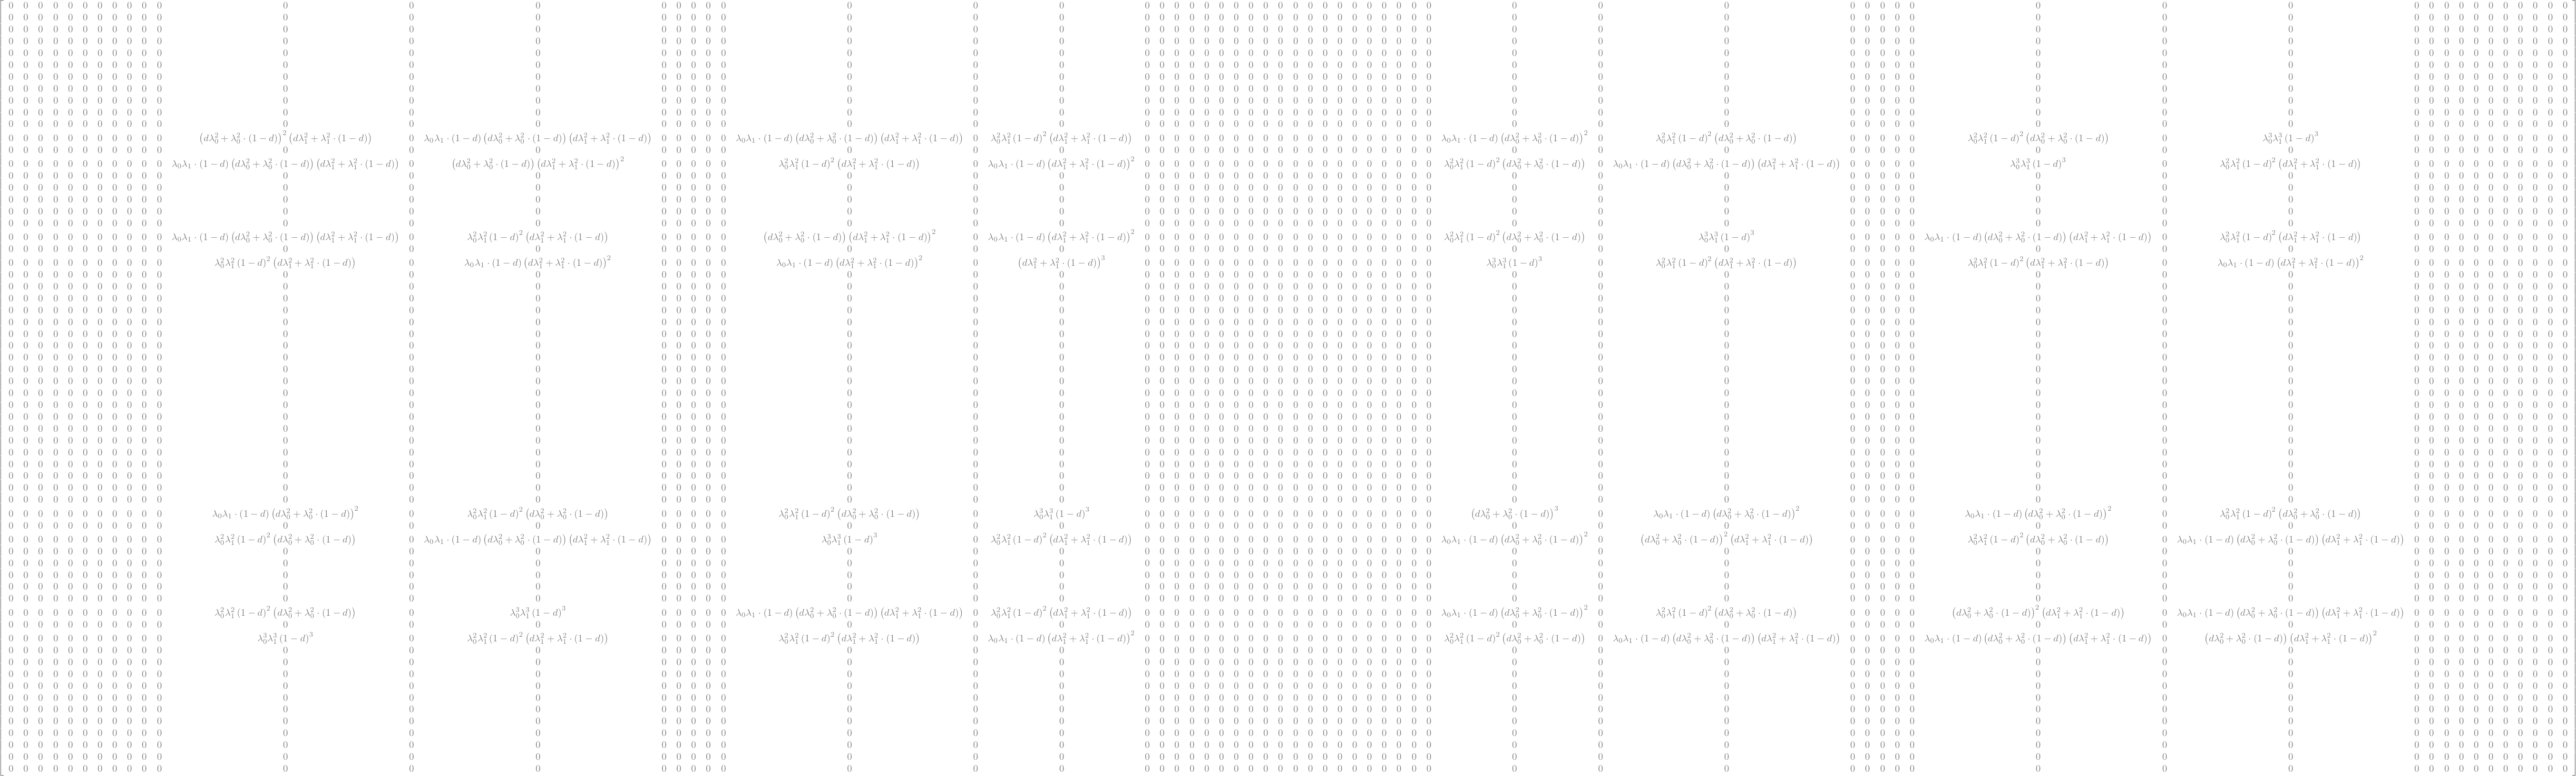

In [7]:
sp.Matrix(total_rho_ordered)

In [8]:
# Setting Measurment 

u, v = sp.symbols('u v')
w, z = sp.symbols('w z')


out_00 = z*state_00 + w*state_11
out_01 = w*state_00 - z*state_11
out_10 = u*state_01 + v*state_10
out_11 = v*state_01 - u*state_10

M_state = np.array([[out_00, out_01],[out_10, out_11]])

In [9]:
## Resulting distribution

from itertools import product

p = np.zeros((2,2,2,2,2,2))
p = p.tolist()


for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
    
    total_M_state = kron(kron(M_state[a1,a2], M_state[b1,b2]), M_state[c1,c2])
    E = np.dot(total_M_state, total_M_state.T)
    p[a1][a2][b1][b2][c1][c2] = np.trace(np.dot(E, total_rho_ordered))

In [10]:
p[1][1][1][1][1][1]

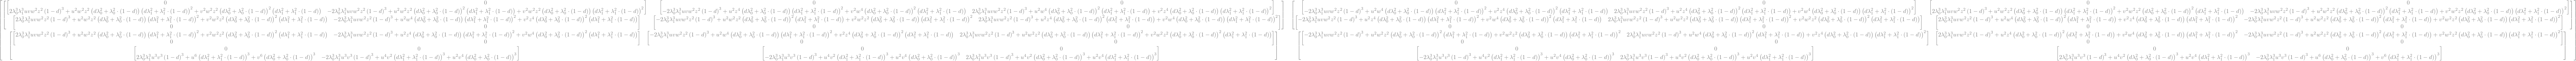

In [11]:
p = sp.Array(p)
p

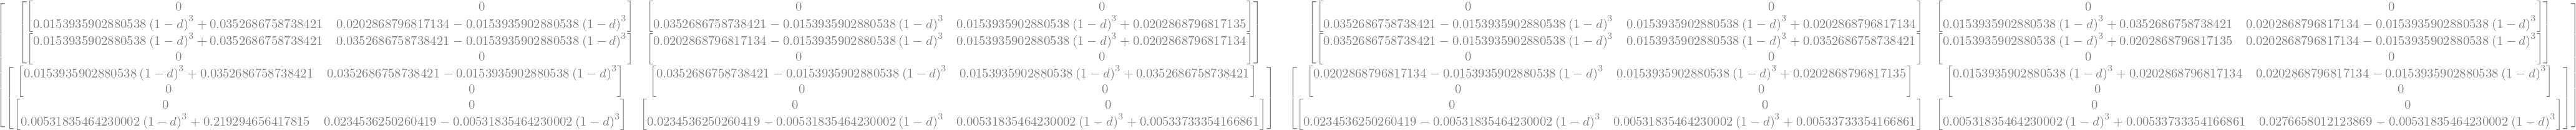

In [10]:
l0 = np.sqrt(1/3)#lambda0
l1 = np.sqrt(1-l0**2)

phi_w = np.pi/4
phi_u = np.pi/10


p_number = p.subs({lambda_0:l0, lambda_1:l1, w:np.cos(phi_w), z:np.sin(phi_w), u:np.cos(phi_u), v:np.sin(phi_u)})
p_number

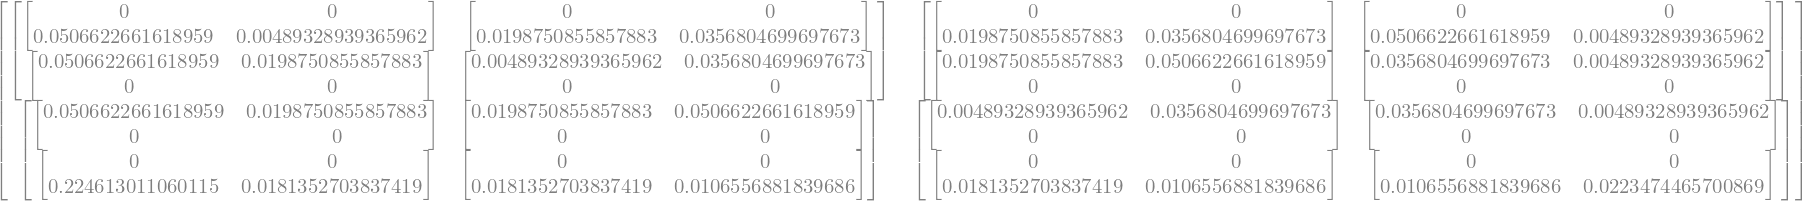

In [11]:
p_quantum = p_number.subs({d:0})
p_quantum

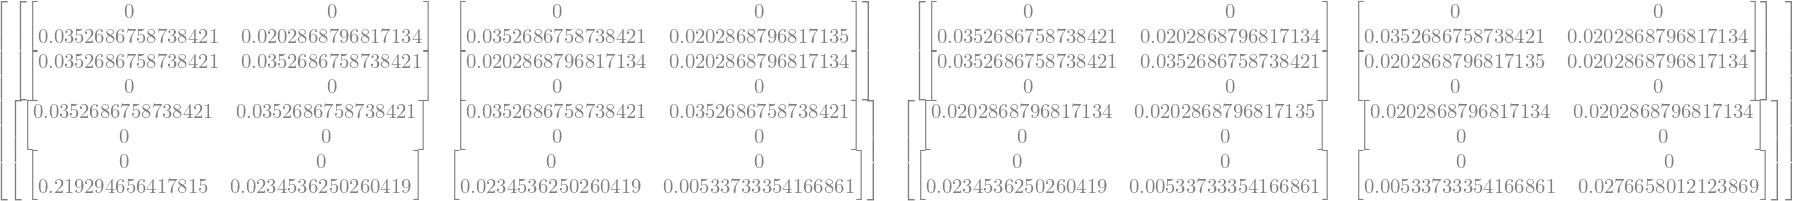

In [12]:
p_classic = p_number.subs({d:1})
p_classic

## The LP for Perfect PTC

$|\psi> = \lambda_0 |01> + \lambda_1 |10>$


with Dephasing noise: 
$\rho = (1-d) |\psi><\psi| + d (\lambda_0^2 |01><01| + \lambda_1^2 |10><10|)$  

for this noise the distribution is still PTC


$d:1 \Rightarrow P_{classic}, \ \ \ \ d:0 \Rightarrow P_{Quantum}$

$P = (1-d)^3 P_{Quantum} + (1-(1-d)^3) P_{classic}$

$e := (1-(1-d)^3)$

$P = (1-e) P_{Quantum} + e P_{classic} = P_{Quantum} + (P_{classic}-P_{Quantum}) \ e$

We want to minimize d => minimize e



The LP is this:

\begin{align}
&P(a_1,a_2,b_1,b_2,c_1,c_2) = \sum_{t_a, t_b, t_c \Rightarrow a_1, b_1, c_1}{ q(t_a)q(t_b)q(t_c) \ P(a_2,b_2,c_2|t_a, t_b, t_c)}\\
&\sum_{a_2,b_2,c_2}{P(a_2,b_2,c_2|t_a, t_b, t_c)} = 1 \ \ \ \forall t_a, t_b, t_c\\
&P(a_2|0, t_b, t_c) = P(a_2|1, t_b, t_c) \Leftrightarrow \sum_{b_2,c_2} {P(a_2,b_2,c_2|0, t_b, t_c)} - \sum_{b_2,c_2}P(a_2,b_2,c_2|1, t_b, t_c) = 0
\end{align}

Which becomes:

\begin{align}
&P_Q(a_1,a_2,b_1,b_2,c_1,c_2) = \sum_{t_a, t_b, t_c \Rightarrow a_1, b_1, c_1}{ q(t_a)q(t_b)q(t_c) \ P(a_2,b_2,c_2|t_a, t_b, t_c)} + (P_Q - P_C)\ e \\
&\sum_{a_2,b_2,c_2}{P(a_2,b_2,c_2|t_a, t_b, t_c)} = 1 \ \ \ \forall t_a, t_b, t_c\\
&P(a_2|0, t_b, t_c) = P(a_2|1, t_b, t_c) \Leftrightarrow \sum_{b_2,c_2} {P(a_2,b_2,c_2|0, t_b, t_c)} - \sum_{b_2,c_2}P(a_2,b_2,c_2|1, t_b, t_c) = 0
\end{align}

In [12]:
l0 = np.sqrt(0.22)#lambda0
l1 = np.sqrt(1-l0**2)

#prob = p.subs({lambda_0:l0, lambda_1:l1, w:1, z:0, u:3/4, v:np.sqrt(1-(3/4)**2)})


q = l0**2  #probability of sending token to right/left?

q_a = [q, 1-q]
q_b = [q, 1-q]
q_c = [q, 1-q]

c = np.zeros(64)  # just to check it sumes to one!
c = np.concatenate([c,[1]]) # for e

# Form the matrix A


#First we consider the probability constraints   --> inside the Loop

            
#second we consider the normalization constraints 

A_2 = np.zeros((8,65))
for ta,tb,tc in product(range(2), repeat=3):
    constraint_it = np.inner([4,2,1],[ta,tb,tc])
    for a2,b2,c2 in product(range(2), repeat=3):
        var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
        A_2[constraint_it, var_it] = 1
    
            
#Third we consider the network independence constraints

A_3a = np.zeros((8,65))
for a2,tb,tc in product(range(2),repeat=3):
    constraint_it = np.inner([4,2,1],[a2,tb,tc])
    for b2,c2,ta in product(range(2),repeat=3):
        var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
        A_3a[constraint_it, var_it] = (-1)**ta
        
        
A_3b = np.zeros((8,65))
for b2,ta,tc in product(range(2),repeat=3):
    constraint_it = np.inner([4,2,1],[b2,ta,tc])
    for a2,c2,tb in product(range(2),repeat=3):
        var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
        A_3b[constraint_it, var_it] = (-1)**tb
        

A_3c = np.zeros((8,65))
for c2,ta,tb in product(range(2),repeat=3):
    constraint_it = np.inner([4,2,1],[c2,ta,tb])
    for a2,b2,tc in product(range(2),repeat=3):
        var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
        A_3c[constraint_it, var_it] = (-1)**tc     
        
        
        
    
N_it = 50

r_list = []
phi_u_list = np.linspace(0, np.pi/2, num = N_it)
phi_w_list = np.linspace(0, np.pi/4, num = N_it//2)  ##### Symmetry

e_map = np.zeros((N_it,N_it//2))

print("Done Rows:")
for i in range(N_it):
    print(i, ", ", end="")
    for j in range(N_it//2):
        
        phi_u = phi_u_list[i]
        phi_w = phi_w_list[j]
        
        prob = p.subs({lambda_0:l0, lambda_1:l1, w:np.cos(phi_w), z:np.sin(phi_w), u:np.cos(phi_u), v:np.sin(phi_u)})    
        
        p_Q = prob.subs({d:0})
        p_C = prob.subs({d:1})
        
        # Form the matrix A_1
        A_1 = np.zeros((64,65))

        for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
            constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
            for ta,tb,tc in product(range(2), repeat=3): 
                if (a1 == (tb+tc+1)%2) and (b1 == (ta+tc+1)%2) and (c1 == (ta+tb+1)%2): # ParityCheck
                    var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
                    A_1[constraint_it, var_it] = q_a[ta]*q_b[tb]*q_c[tc]
                    A_1[constraint_it, 64] = p_Q[a1][a2][b1][b2][c1][c2] - p_C[a1][a2][b1][b2][c1][c2]  # e coef .. 
                    #This line should be inside the for loop as we need the coef_e to exist only for valid a1 b1 c1 

        
        A = np.concatenate([A_1,A_2,A_3a,A_3b,A_3c])  

        #remove the redundant rows
        _, inds = sp.Matrix(A).T.rref()   # I transposed to check for the rows 
        A = A[np.array(inds)]
        #print("Number of independent equations", A.shape[0])
        #print("Size of The LP system: ", A.shape)


        
        # Form the vector b            
        b_1 = np.zeros(64)
        for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
            constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
            b_1[constraint_it] = p_Q[a1][a2][b1][b2][c1][c2]


        b_2 = np.ones(8)
        b_3 = np.zeros(24)


        b = np.concatenate([b_1,b_2,b_3])
        b = b[np.array(inds)] # remove the redundent



        res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))
        
        e_map[i, j] = res.fun

## Add the other half side for w
e_map_flip = np.flip(e_map, 1)
e_map_final = np.concatenate((e_map, e_map_flip), axis=1)


Done Rows:
0 , 

/var/folders/hp/59m8q4js7lx0mprsqm5s803c0000gn/T/ipykernel_72938/2000828905.py:120: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))
/var/folders/hp/59m8q4js7lx0mprsqm5s803c0000gn/T/ipykernel_72938/2000828905.py:120: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.28006e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/pyth

1 , 

/var/folders/hp/59m8q4js7lx0mprsqm5s803c0000gn/T/ipykernel_72938/2000828905.py:120: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.90709e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


2 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.58076e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


3 , 4 , 5 , 6 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.28713e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


7 , 8 , 9 , 10 , 11 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.33462e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.05817e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.07789e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.59775e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.9721e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.92029e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.11783e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.20089e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.54158e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.95355e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.19996e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.38013e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.26528e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.28225e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.77254e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.17016e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.05832e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.33035e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.94555e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.90443e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.64178e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.8282e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.985e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.12923e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.86491e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.25382e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.36505e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.45597e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.08142e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.19358e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.79447e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.04111e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.20739e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.8744e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.34413e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.23035e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.0445e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.92805e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.31872e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.80246e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.68284e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.05678e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.52721e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.35386e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.6713e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.52364e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.32093e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.38177e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.40471e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.88519e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.61884e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.04371e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.19989e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.13817e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.2273e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.3879e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarnin

12 , 13 , 14 , 15 , 16 , 17 , 18 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.77747e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.5495e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.48207e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.29792e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

19 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.82665e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.30339e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.5118e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


20 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.53923e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


21 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.22766e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.02981e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.64421e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.04795e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


22 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.16255e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10376e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.45496e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


23 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.40484e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


24 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.90302e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


25 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.1188e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


26 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.94247e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.54719e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10031e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


27 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.99398e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.57049e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


28 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.69002e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


29 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.76291e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.07361e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


30 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.96489e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


31 , 32 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.65927e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0775e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.81463e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


33 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.45785e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.0074e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


34 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.80205e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


35 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.20875e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.34056e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


36 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.67027e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


37 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.00499e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


38 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.57613e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.38438e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


39 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.26737e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.95111e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


40 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.27977e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.32151e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


41 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.59739e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.29846e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.64585e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


42 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.49558e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


43 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10813e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


44 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.76548e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.5669e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.18755e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.34792e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

45 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.80311e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.14671e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.0331e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.49996e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

46 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.39746e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.39812e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.51801e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.82628e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

47 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.04982e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.76919e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.7951e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.95473e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

48 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.58529e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.12612e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.33765e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.40092e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

49 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10166e-24): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.97813e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.02811e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.04283e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

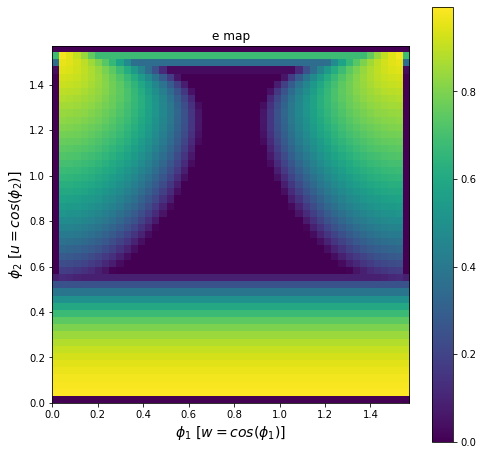

In [13]:
fig, ax = plt.subplots(figsize=(8,8))

ax.set_title("e map")


plt.imshow(e_map_final,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

# Add colorbar
plt.colorbar()

plt.xlabel("$\phi_1 \ [w=cos(\phi_1)]$",
             size = 14)
plt.ylabel("$\phi_2 \ [u=cos(\phi_2)]$",
             size = 14)

plt.show()

$d=1-\sqrt[3]{1-e}$

Max d is  80.58318815708631 for:
$phi_1$ 0.6217735460229799
$ph2_1$ 0.0320570678937734


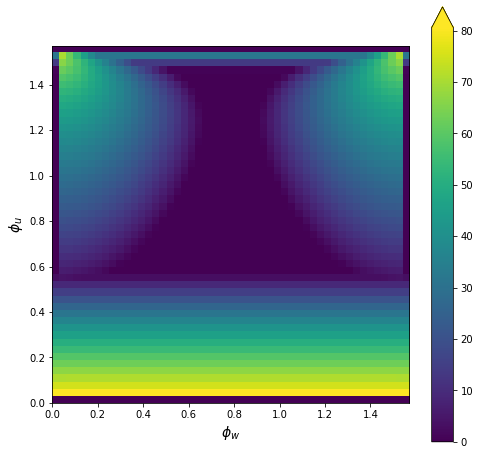

In [14]:
d_map = 1-((1-e_map_final)**(1/3))

d_map = d_map*100 ##### in %

fig, ax = plt.subplots(figsize=(8,8))

#ax.set_title("d map")


plt.imshow(d_map,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

# Add colorbar
plt.colorbar(extend="max")

plt.xlabel("$\phi_w$",
             size = 14)
plt.ylabel("$\phi_u$",
             size = 14)

from numpy import unravel_index

i_max, j_max = unravel_index(d_map.argmax(), d_map.shape)
phi_u_max = phi_u_list[i_max]
phi_w_max = phi_w_list[j_max]

print("Max d is ", np.max(d_map), "for:")
print("$phi_1$", phi_w_max)
print("$ph2_1$", phi_u_max)

plt.show()

In [17]:
# Save the data
np.savez('Dephasing_noise_LP_50_22.npz', e_map_final=e_map_final, d_map=d_map, phi_u_list=phi_u_list , phi_w_list=phi_w_list)


Max d is  0.8058318815708632 for:
$phi_1$ 0.6217735460229799
$ph2_1$ 0.0320570678937734


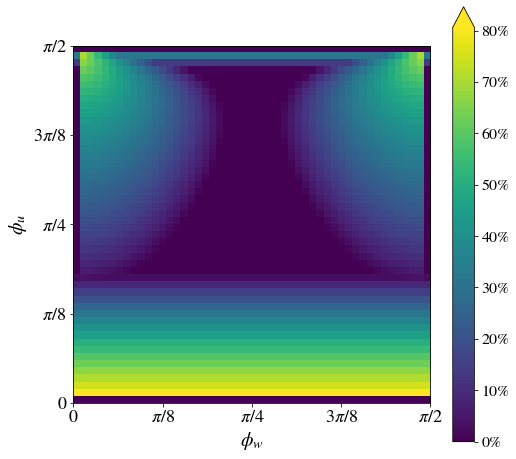

In [15]:
import matplotlib
import matplotlib.ticker as mtick
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

matplotlib.rcParams['axes.titlepad'] = 10  # pad is in points...


d_map = 1-((1-e_map_final)**(1/3))

d_map = d_map ##### in %

fig, ax = plt.subplots(figsize=(8,8))

#ax.set_title("d map")
#ax.set_title("Dephasing Noise Map", size = 20)



plt.imshow(d_map,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

# Add colorbar
cbar= plt.colorbar(extend="max")
cbar.ax.tick_params(labelsize=16)

# Format the colorbar to display percentages
formatter = mtick.FuncFormatter(lambda x, pos: '{:.0%}'.format(x))
cbar.ax.yaxis.set_major_formatter(formatter)

plt.xlabel("$\phi_w$", size = 20)
plt.ylabel("$\phi_u$", size = 20)


theta = np.linspace(0, np.pi/2, 5)
plt.xticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

plt.yticks(theta, ['0','$'+r'{\pi/8}$','$'+r'{\pi/4}$','$'+r'{3\pi/8}$', '$'+r'{\pi/2}$'])

plt.yticks(fontsize=18)
plt.xticks(fontsize=18)



from numpy import unravel_index

i_max, j_max = unravel_index(d_map.argmax(), d_map.shape)
phi_u_max = phi_u_list[i_max]
phi_w_max = phi_w_list[j_max]

print("Max d is ", np.max(d_map), "for:")
print("$phi_1$", phi_w_max)
print("$ph2_1$", phi_u_max)



plt.show()

In [16]:
fig.savefig('Dephasing_plot_50_22.pdf', bbox_inches='tight') 

Max d is  0.7425447771224392 for:
$phi_1$ 0.6217735460229799
$ph2_1$ 0.0320570678937734


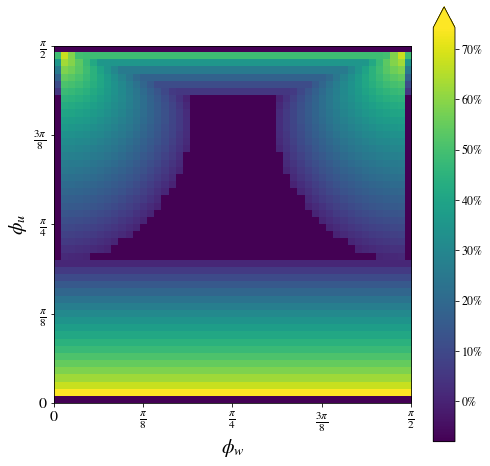

In [127]:
import matplotlib
import matplotlib.ticker as mtick
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'


d_map = 1-((1-e_map_final)**(1/3))

d_map = -0.08*(local_map) + d_map

fig, ax = plt.subplots(figsize=(8,8))

#ax.set_title("d map")


plt.imshow(d_map,origin='lower', extent=[0,np.pi/2,0,np.pi/2])

# Add colorbar
cbar= plt.colorbar(extend="max")
cbar.ax.tick_params(labelsize=12)

# Format the colorbar to display percentages
formatter = mtick.FuncFormatter(lambda x, pos: '{:.0%}'.format(x))
cbar.ax.yaxis.set_major_formatter(formatter)

plt.xlabel("$\phi_w$", size = 20)
plt.ylabel("$\phi_u$", size = 20)


theta = np.linspace(0, np.pi/2, 5)
plt.xticks(theta, ['0','$'+r'\frac{\pi}{8}$','$'+r'\frac{\pi}{4}$','$'+r'\frac{3\pi}{8}$', '$'+r'\frac{\pi}{2}$'])

plt.yticks(theta, ['0','$'+r'\frac{\pi}{8}$','$'+r'\frac{\pi}{4}$','$'+r'\frac{3\pi}{8}$', '$'+r'\frac{\pi}{2}$'])

plt.yticks(fontsize=16)
plt.xticks(fontsize=16)



from numpy import unravel_index

i_max, j_max = unravel_index(d_map.argmax(), d_map.shape)
phi_u_max = phi_u_list[i_max]
phi_w_max = phi_w_list[j_max]

print("Max d is ", np.max(d_map), "for:")
print("$phi_1$", phi_w_max)
print("$ph2_1$", phi_u_max)



plt.show()

In [54]:
np.linspace(0, np.pi/2, 3)

array([0.        , 0.78539816, 1.57079633])

# 1 D Plot 

In [21]:
np.linspace(0, np.pi/2, num = 100)

array([0.        , 0.01586663, 0.03173326, 0.04759989, 0.06346652,
       0.07933315, 0.09519978, 0.11106641, 0.12693304, 0.14279967,
       0.1586663 , 0.17453293, 0.19039955, 0.20626618, 0.22213281,
       0.23799944, 0.25386607, 0.2697327 , 0.28559933, 0.30146596,
       0.31733259, 0.33319922, 0.34906585, 0.36493248, 0.38079911,
       0.39666574, 0.41253237, 0.428399  , 0.44426563, 0.46013226,
       0.47599889, 0.49186552, 0.50773215, 0.52359878, 0.53946541,
       0.55533203, 0.57119866, 0.58706529, 0.60293192, 0.61879855,
       0.63466518, 0.65053181, 0.66639844, 0.68226507, 0.6981317 ,
       0.71399833, 0.72986496, 0.74573159, 0.76159822, 0.77746485,
       0.79333148, 0.80919811, 0.82506474, 0.84093137, 0.856798  ,
       0.87266463, 0.88853126, 0.90439789, 0.92026451, 0.93613114,
       0.95199777, 0.9678644 , 0.98373103, 0.99959766, 1.01546429,
       1.03133092, 1.04719755, 1.06306418, 1.07893081, 1.09479744,
       1.11066407, 1.1265307 , 1.14239733, 1.15826396, 1.17413

In [31]:
np.logspace(-10, np.log10(np.pi/2), num = 100)

array([1.00000000e-10, 1.26762592e-10, 1.60687547e-10, 2.03691699e-10,
       2.58204876e-10, 3.27307193e-10, 4.14903080e-10, 5.25941898e-10,
       6.66697580e-10, 8.45123132e-10, 1.07129998e-09, 1.35800763e-09,
       1.72144566e-09, 2.18214913e-09, 2.76614880e-09, 3.50644191e-09,
       4.44485664e-09, 5.63441547e-09, 7.14233108e-09, 9.05380398e-09,
       1.14768366e-08, 1.45483355e-08, 1.84418471e-08, 2.33773633e-08,
       2.96337516e-08, 3.75645116e-08, 4.76177485e-08, 6.03614921e-08,
       7.65157917e-08, 9.69934006e-08, 1.22951348e-07, 1.55856316e-07,
       1.97567505e-07, 2.50441690e-07, 3.17466377e-07, 4.02428607e-07,
       5.10128932e-07, 6.46652655e-07, 8.19713665e-07, 1.03909029e-06,
       1.31717778e-06, 1.66968869e-06, 2.11654065e-06, 2.68298179e-06,
       3.40101725e-06, 4.31121761e-06, 5.46501117e-06, 6.92758980e-06,
       8.78159237e-06, 1.11317741e-05, 1.41109253e-05, 1.78873746e-05,
       2.26744997e-05, 2.87427835e-05, 3.64350972e-05, 4.61860735e-05,
      

In [32]:
def RGB4_Dephasing_plot(l0, N_it):    
    
    l1 = np.sqrt(1-l0**2)

    #prob = p.subs({lambda_0:l0, lambda_1:l1, w:1, z:0, u:3/4, v:np.sqrt(1-(3/4)**2)})


    q = l0**2  #probability of sending token to right/left?

    q_a = [q, 1-q]
    q_b = [q, 1-q]
    q_c = [q, 1-q]

    c = np.zeros(64)  # just to check it sumes to one!
    c = np.concatenate([c,[1]]) # for e

    # Form the matrix A


    #First we consider the probability constraints   --> inside the Loop


    #second we consider the normalization constraints 

    A_2 = np.zeros((8,65))
    for ta,tb,tc in product(range(2), repeat=3):
        constraint_it = np.inner([4,2,1],[ta,tb,tc])
        for a2,b2,c2 in product(range(2), repeat=3):
            var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
            A_2[constraint_it, var_it] = 1


    #Third we consider the network independence constraints

    A_3a = np.zeros((8,65))
    for a2,tb,tc in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[a2,tb,tc])
        for b2,c2,ta in product(range(2),repeat=3):
            var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
            A_3a[constraint_it, var_it] = (-1)**ta


    A_3b = np.zeros((8,65))
    for b2,ta,tc in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[b2,ta,tc])
        for a2,c2,tb in product(range(2),repeat=3):
            var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
            A_3b[constraint_it, var_it] = (-1)**tb


    A_3c = np.zeros((8,65))
    for c2,ta,tb in product(range(2),repeat=3):
        constraint_it = np.inner([4,2,1],[c2,ta,tb])
        for a2,b2,tc in product(range(2),repeat=3):
            var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
            A_3c[constraint_it, var_it] = (-1)**tc     

            

    #phi_u_list = np.linspace(0, np.pi/2, num = N_it)
    phi_u_list = np.logspace(-10, np.log10(np.pi/2), num = N_it)

    e_map = np.zeros(N_it)

    print("Done Rows:")
    for i in range(N_it):
        print(i, ", ", end="")

        phi_u = phi_u_list[i]
        phi_w = 0

        prob = p.subs({lambda_0:l0, lambda_1:l1, w:np.cos(phi_w), z:np.sin(phi_w), u:np.cos(phi_u), v:np.sin(phi_u)})    

        p_Q = prob.subs({d:0})
        p_C = prob.subs({d:1})

        # Form the matrix A_1
        A_1 = np.zeros((64,65))

        for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
            constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
            for ta,tb,tc in product(range(2), repeat=3): 
                if (a1 == (tb+tc+1)%2) and (b1 == (ta+tc+1)%2) and (c1 == (ta+tb+1)%2): # ParityCheck
                    var_it = np.inner([32,16,8,4,2,1],[a2,b2,c2,ta,tb,tc])
                    A_1[constraint_it, var_it] = q_a[ta]*q_b[tb]*q_c[tc]
                    A_1[constraint_it, 64] = p_Q[a1][a2][b1][b2][c1][c2] - p_C[a1][a2][b1][b2][c1][c2]  # e coef .. 
                    #This line should be inside the for loop as we need the coef_e to exist only for valid a1 b1 c1 


        A = np.concatenate([A_1,A_2,A_3a,A_3b,A_3c])  

        #remove the redundant rows
        _, inds = sp.Matrix(A).T.rref()   # I transposed to check for the rows 
        A = A[np.array(inds)]
        #print("Number of independent equations", A.shape[0])
        #print("Size of The LP system: ", A.shape)



        # Form the vector b            
        b_1 = np.zeros(64)
        for a1,a2,b1,b2,c1,c2 in product(range(2), repeat=6):
            constraint_it = np.inner([32,16,8,4,2,1],[a1,a2,b1,b2,c1,c2])
            b_1[constraint_it] = p_Q[a1][a2][b1][b2][c1][c2]


        b_2 = np.ones(8)
        b_3 = np.zeros(24)


        b = np.concatenate([b_1,b_2,b_3])
        b = b[np.array(inds)] # remove the redundent



        res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))

        e_map[i] = res.fun
        
    return e_map



In [33]:
l0 = np.cos(0.342*np.pi)#lambda0
N_it = 100
e_array = RGB4_Dephasing_plot(l0, N_it)

d_array = 1-((1-e_array)**(1/3))

Done Rows:
0 , 

/var/folders/hp/59m8q4js7lx0mprsqm5s803c0000gn/T/ipykernel_72938/850547365.py:116: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))


1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 

/var/folders/hp/59m8q4js7lx0mprsqm5s803c0000gn/T/ipykernel_72938/850547365.py:116: OptimizeWarning: Solving system with option 'cholesky':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'cholesky' to False.
  res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))
/var/folders/hp/59m8q4js7lx0mprsqm5s803c0000gn/T/ipykernel_72938/850547365.py:116: OptimizeWarning: Solving system with option 'sym_pos':True failed. It is normal for this to happen occasionally, especially as the solution is approached. However, if you see this frequently, consider setting option 'sym_pos' to False.
  res = linprog(c, A_eq=A, b_eq=b, bounds=(0,1))
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.7843e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3

60 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.46791e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.34208e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.82768e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.89873e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.99882e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.62357e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.88162e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.12006e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.79698e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.53535e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.27086e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.53496e-29): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.78692e-49): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.78824e-49): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.91191e-53): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.931e-58): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarnin

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.63103e-87): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.04227e-82): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.16863e-78): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.1561e-86): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

61 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.67834e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.29336e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.9886e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.05249e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

62 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.15166e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.13836e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.07974e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.53436e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


63 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.78433e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.76688e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.54499e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


64 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.08333e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.04923e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.39544e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.83182e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

65 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.18724e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.42877e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.43991e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.68438e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

66 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.72011e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


67 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0648e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.3526e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.48298e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.37223e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


68 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.60703e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.60828e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


69 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0359e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.38261e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


70 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.63751e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


71 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.15417e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.88667e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.91143e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


72 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.18149e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.9595e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.39705e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


73 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.32408e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.10034e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.28866e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.44765e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


74 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.12577e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.43912e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.81261e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


75 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.57905e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


76 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.85666e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=5.50145e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.07819e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.0032e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarni

77 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.07025e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=9.4499e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.92173e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


78 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=8.78814e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.88358e-19): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.78355e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.84734e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarn

79 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.16249e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.23064e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


80 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=6.34324e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.74481e-23): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


81 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.739e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


82 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.0062e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


83 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=3.73915e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


84 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=7.5389e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


85 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.51469e-20): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)
/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=1.20341e-22): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


86 , 87 , 88 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=2.73253e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


89 , 

/Users/sadra/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_linprog_ip.py:117: LinAlgWarning: Ill-conditioned matrix (rcond=4.08754e-21): result may not be accurate.
  return sp.linalg.solve(M, r, sym_pos=sym_pos)


90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

(array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633]),
 [Text(0.0, 0, '0'),
  Text(0.39269908169872414, 0, '$\\frac{\\pi}{8}$'),
  Text(0.7853981633974483, 0, '$\\frac{\\pi}{4}$'),
  Text(1.1780972450961724, 0, '$\\frac{3\\pi}{8}$'),
  Text(1.5707963267948966, 0, '$\\frac{\\pi}{2}$')])

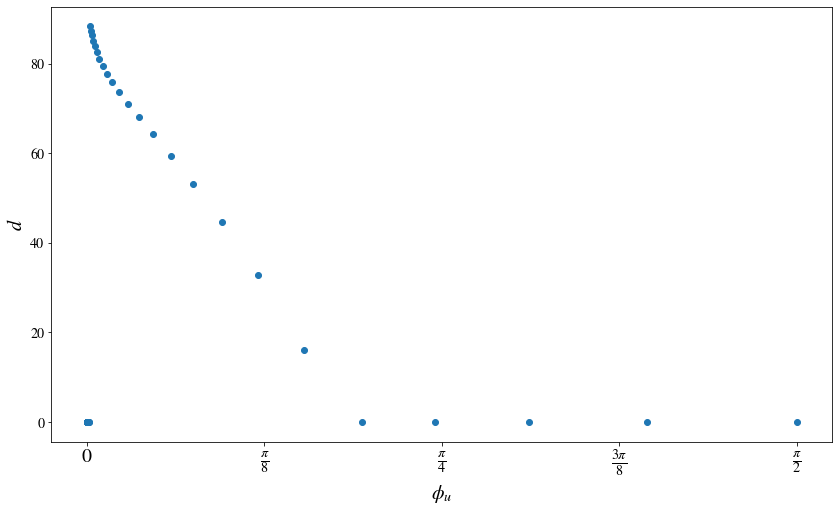

In [36]:
fig, ax = plt.subplots(figsize=(14,8))

phi_u_list = np.logspace(-10, np.log10(np.pi/2), num = N_it)

plt.scatter(phi_u_list, 100*d_array)

plt.xlabel("$\phi_u$", size = 20)
plt.ylabel("$d$", size = 20)


theta = np.linspace(0, np.pi/2, 5)
plt.xticks(theta, ['0','$'+r'\frac{\pi}{8}$','$'+r'\frac{\pi}{4}$','$'+r'\frac{3\pi}{8}$', '$'+r'\frac{\pi}{2}$'])

plt.yticks(fontsize=14)
plt.xticks(fontsize=20)

In [37]:
np.max(d_array)

(array([0.        , 0.39269908, 0.78539816, 1.17809725, 1.57079633]),
 [Text(0.0, 0, '0'),
  Text(0.39269908169872414, 0, '$\\frac{\\pi}{8}$'),
  Text(0.7853981633974483, 0, '$\\frac{\\pi}{4}$'),
  Text(1.1780972450961724, 0, '$\\frac{3\\pi}{8}$'),
  Text(1.5707963267948966, 0, '$\\frac{\\pi}{2}$')])

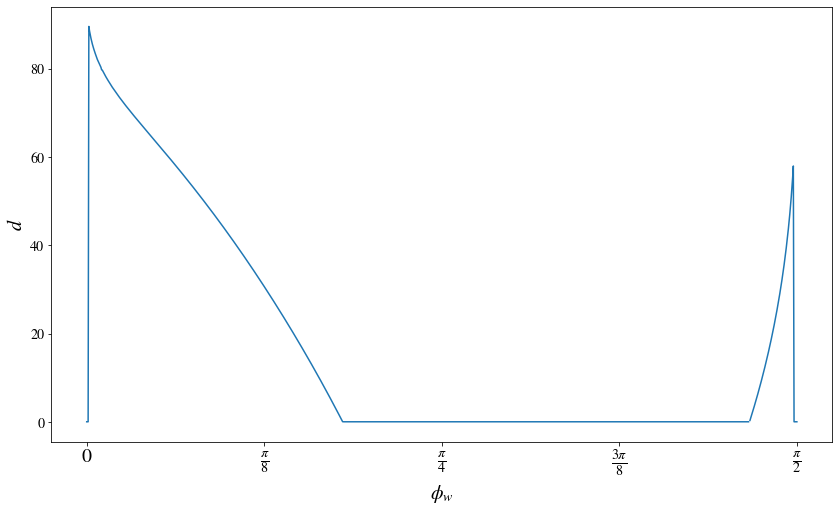

In [160]:
fig, ax = plt.subplots(figsize=(14,8))

phi_u_list = np.linspace(0, np.pi/2, num = N_it)

plt.plot(phi_u_list, 100*d_array)

plt.xlabel("$\phi_u$", size = 20)
plt.ylabel("$d$", size = 20)


theta = np.linspace(0, np.pi/2, 5)
plt.xticks(theta, ['0','$'+r'\frac{\pi}{8}$','$'+r'\frac{\pi}{4}$','$'+r'\frac{3\pi}{8}$', '$'+r'\frac{\pi}{2}$'])

plt.yticks(fontsize=14)
plt.xticks(fontsize=20)

In [161]:
#fig.savefig('Dephasing_plot_RGB4_cos342.pdf', bbox_inches='tight') 